In [1]:
import zipfile

zip_path = "/home/swc/Downloads/coords_Non.zip"

In [2]:
extract = "/home/swc/Downloads/data"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract)
print("Done")

Done


In [3]:
import pandas as pd

df= pd.read_csv("/home/swc/Downloads/data/coords_Non.csv")

In [4]:
df.head()

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z520,v520,x521,y521,z521,v521,x522,y522,z522,v522
0,Hold,0.407733,0.129086,-0.778690,0.993342,0.421445,0.090329,-0.737180,0.993019,0.434254,...,-0.078738,0.0,0.911478,0.763253,-0.085874,0.0,0.918760,0.787047,-0.091987,0.0
1,Hold,0.405080,0.119946,-0.982599,0.993911,0.419926,0.084866,-0.928936,0.993197,0.433784,...,-0.081532,0.0,0.907795,0.763564,-0.088705,0.0,0.912692,0.788697,-0.094718,0.0
2,Hold,0.397699,0.109015,-0.836984,0.994504,0.419621,0.072088,-0.792933,0.993758,0.433126,...,-0.077996,0.0,0.909169,0.768035,-0.084063,0.0,0.914087,0.792701,-0.089030,0.0
3,Hold,0.395727,0.105420,-0.799126,0.994938,0.418676,0.067525,-0.756440,0.993735,0.432624,...,-0.073175,0.0,0.910434,0.768192,-0.078608,0.0,0.918212,0.791781,-0.082382,0.0
4,Hold,0.394592,0.100825,-0.968101,0.995398,0.418038,0.063968,-0.916498,0.994151,0.432285,...,-0.080001,0.0,0.810127,0.742485,-0.083544,0.0,0.814252,0.768813,-0.084207,0.0


In [5]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

def process_data(df=None, frames=30, test=0.2, random=42):
    print("Processing data")
    
    # If df is None, load from file
    if df is None:
        df = pd.read_csv("/home/swc/Downloads/yolov9/yolov9/data/coords_Non.csv", sep=",")
    
    # Ensure the first column is actually the label column
    class_columns = df.columns[0]  # Assuming the first column is the class column, update if it's different
    
    # Check if class_columns is actually a label column (you may need to adjust based on your data structure)
    print(f"Class column: {class_columns}")
    
    # Extract all labels from the class column
    all_labels = df[class_columns].values
    
    # Encode labels into numeric format
    label_encoder = LabelEncoder()
    all_numeric_labels = label_encoder.fit_transform(all_labels)
    class_names = label_encoder.classes_
    
    print(f"Found {len(class_names)} classes: {class_names}")
    
    # Drop the class column from features
    features_df = df.drop(columns=[class_columns])
    all_columns = features_df.columns.tolist()
    num_features = len(all_columns)
    
    print(f"Total features: {num_features}")
    
    # Handle missing values if any
    missing_values = features_df.isnull().sum().sum()
    print(f"Missing values: {missing_values}")
    
    if missing_values > 0:
        # Fill missing values with zeros (or use a more advanced method depending on your data)
        features_df.fillna(0, inplace=True)
        print("Filled missing values with 0")
    
    # Normalize the feature data
    print("Normalizing data")
    scaler = MinMaxScaler()
    normalized_features = scaler.fit_transform(features_df)
    
    # Organizing data into sequences of frames
    print(f"Organizing data into {frames}-frame sequences")
    num_frames = len(normalized_features)
    num_complete_sequences = num_frames // frames
    total_frames_used = num_complete_sequences * frames
    trimmed_features = normalized_features[:total_frames_used]
    trimmed_labels = all_numeric_labels[:total_frames_used]
    
    print(f"Using {total_frames_used} frames out of {num_frames} total frames")
    print(f"Creating {num_complete_sequences} complete sequences")
    
    # Prepare the sequences (X) and labels (y)
    X_sequences = np.zeros((num_complete_sequences, frames, num_features))
    y_sequences = np.zeros(num_complete_sequences)
    
    for i in range(num_complete_sequences):
        start = i * frames
        end = start + frames
        X_sequences[i] = trimmed_features[start:end]
        
        # Get the labels for this sequence (most common label in the sequence)
        sequence_labels = trimmed_labels[start:end]
        
        # Use np.unique to find the most common label in the sequence
        unique_labels, counts = np.unique(sequence_labels, return_counts=True)
        if len(unique_labels) > 0:
            most_common_idx = np.argmax(counts)
            y_sequences[i] = unique_labels[most_common_idx]
        else:
            # Fallback in case of an empty sequence, though this shouldn't normally happen
            y_sequences[i] = 0
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_sequences, y_sequences, test_size=test, random_state=random
    )
    
    print(f"X_train shape: {X_train.shape}")
    print(f"Test shape: {X_test.shape}")
    
    return {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "class_names": class_names,
        "scaler": scaler,
        "label_encoder": label_encoder,
        "num_features": num_features,
        "frames_per_gesture": frames,
        "num_classes": len(class_names)
    }



In [8]:
def visualize_sequence(sequence, class_name, num_frames_to_show=5):

    # Select frames to visualize (evenly spaced)
    total_frames = sequence.shape[0]
    frame_indices = np.linspace(0, total_frames-1, num_frames_to_show, dtype=int)
    
    fig, axes = plt.subplots(1, num_frames_to_show, figsize=(15, 3))
    fig.suptitle(f'Gesture: {class_name}', fontsize=16)
    
    for i, frame_idx in enumerate(frame_indices):
        frame = sequence[frame_idx]
        
        # Assuming the first 33*4 features are pose landmarks (x, y, z, visibility)
        pose_features = frame[:33*4].reshape(33, 4)
        
        # Extract x, y coordinates for visualization
        x_coords = pose_features[:, 0]
        y_coords = pose_features[:, 1]
        visibility = pose_features[:, 3]
        
        # Plot only visible landmarks
        visible_mask = visibility > 0.5
        axes[i].scatter(x_coords[visible_mask], y_coords[visible_mask], color='blue', s=30)
        axes[i].set_xlim(0, 1)
        axes[i].set_ylim(0, 1)
        axes[i].set_title(f'Frame {frame_idx}')
        axes[i].invert_yaxis()  # Invert y-axis to match image coordinates
    
    plt.tight_layout()
    plt.show()


Processing data
Class column: class
Found 25 classes: ['Auto' 'Backward' 'Collect_pen' 'Collect_screw' 'Collect_tape' 'Down'
 'Feeding' 'Forward' 'Four' 'Give_screw' 'Hold' 'Leave' 'Left' 'Manual'
 'Need_assist' 'Ok' 'One' 'Release' 'Right' 'Stop_feeding' 'Tape' 'Three'
 'Two' 'Up' 'Writing']
Total features: 2088
Missing values: 0
Normalizing data
Organizing data into 30-frame sequences
Using 18270 frames out of 18273 total frames
Creating 609 complete sequences
X_train shape: (487, 30, 2088)
Test shape: (122, 30, 2088)

Data Processing Summary:
Number of gesture classes: 25
Class names: ['Auto' 'Backward' 'Collect_pen' 'Collect_screw' 'Collect_tape' 'Down'
 'Feeding' 'Forward' 'Four' 'Give_screw' 'Hold' 'Leave' 'Left' 'Manual'
 'Need_assist' 'Ok' 'One' 'Release' 'Right' 'Stop_feeding' 'Tape' 'Three'
 'Two' 'Up' 'Writing']
Features per frame: 2088
Frames per gesture: 30
Training sequences: 487
Test sequences: 122

Visualizing sample sequence (class: Ok)...


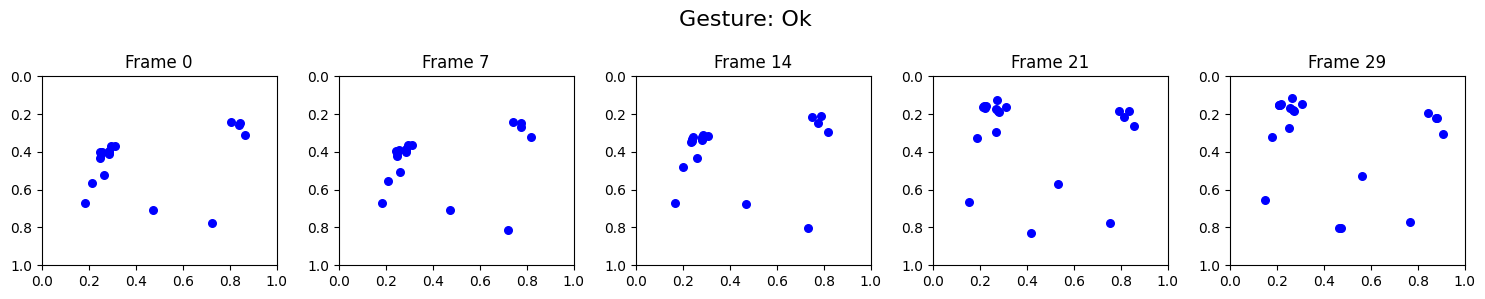

In [9]:
if __name__ == "__main__":
    # Sample code to run the pipeline (replace with your actual file path)
    data_path = pd.read_csv("/home/swc/Downloads/data/coords_Non.csv")
    
    try:
        # Process the data
        processed_data = process_data(data_path, frames=30)
        
        # Print summary info
        print("\nData Processing Summary:")
        print(f"Number of gesture classes: {processed_data['num_classes']}")
        print(f"Class names: {processed_data['class_names']}")
        print(f"Features per frame: {processed_data['num_features']}")
        print(f"Frames per gesture: {processed_data['frames_per_gesture']}")
        print(f"Training sequences: {processed_data['X_train'].shape[0]}")
        print(f"Test sequences: {processed_data['X_test'].shape[0]}")
        
        # Visualize a sample sequence
        sample_idx = 0
        class_idx = int(processed_data['y_train'][sample_idx])
        class_name = processed_data['class_names'][class_idx]
        print(f"\nVisualizing sample sequence (class: {class_name})...")
        visualize_sequence(processed_data['X_train'][sample_idx], class_name)
        
    except Exception as e:
        print(f"Error processing data: {e}")

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Bidirectional

def build_bilstm_model(input_shape, classes):
    model = Sequential([
        Input(shape=input_shape),  # (30, 2088)
        
        Bidirectional(LSTM(128, return_sequences=True, activation="relu")),  
        BatchNormalization(),
        Dropout(0.3),

        Bidirectional(LSTM(64, return_sequences=True, activation="relu")),
        BatchNormalization(),
        Dropout(0.3),

        Bidirectional(LSTM(32, return_sequences=False, activation="relu")),  # Final LSTM layer (No sequences)
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation="relu"),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation="relu"),
        BatchNormalization(),
        Dropout(0.3),

        Dense(classes, activation="softmax")
    ])
    return model


2025-03-13 14:23:19.795373: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 14:23:20.311798: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 14:23:20.314018: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-13 14:23:21.282977: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [17]:
input_shape = (30, 2088)  # (time_steps, features)
num_classes = 25

# Create the model instance
bilstm_model = build_bilstm_model(input_shape, num_classes)

# Print the model summary
bilstm_model.summary()  # ✅ CORRECT


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 30, 256)           2270208   
 onal)                                                           
                                                                 
 batch_normalization_5 (Bat  (None, 30, 256)           1024      
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 30, 256)           0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 30, 128)           164352    
 onal)                                                           
                                                                 
 batch_normalization_6 (Bat  (None, 30, 128)           512       
 chNormalization)                                     

In [21]:
data = process_data(data_path, frames=30)
X_train = data["X_train"]
y_train = data["y_train"]
X_test = data["X_test"]
y_test = data["y_test"]
num_features = data["num_features"]
num_classes = data["num_classes"]


Processing data
Class column: class
Found 25 classes: ['Auto' 'Backward' 'Collect_pen' 'Collect_screw' 'Collect_tape' 'Down'
 'Feeding' 'Forward' 'Four' 'Give_screw' 'Hold' 'Leave' 'Left' 'Manual'
 'Need_assist' 'Ok' 'One' 'Release' 'Right' 'Stop_feeding' 'Tape' 'Three'
 'Two' 'Up' 'Writing']
Total features: 2088
Missing values: 0
Normalizing data
Organizing data into 30-frame sequences
Using 18270 frames out of 18273 total frames
Creating 609 complete sequences
X_train shape: (487, 30, 2088)
Test shape: (122, 30, 2088)


In [22]:
input_shape = (30, 2088)  # (time_steps, features)
num_classes = 25
bilstm_model = build_bilstm_model(input_shape, num_classes)
bilstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = bilstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/50
8/8 [==============================] - 9s 414ms/step - loss: 3.9160 - accuracy: 0.0390 - val_loss: 91.4562 - val_accuracy: 0.0328
Epoch 2/50
8/8 [==============================] - 3s 332ms/step - loss: 3.9874 - accuracy: 0.0308 - val_loss: 116.0266 - val_accuracy: 0.0082
Epoch 3/50
8/8 [==============================] - 3s 333ms/step - loss: 3.9752 - accuracy: 0.0431 - val_loss: 42.5482 - val_accuracy: 0.0328
Epoch 4/50
8/8 [==============================] - 3s 335ms/step - loss: 3.7523 - accuracy: 0.0452 - val_loss: 61.3609 - val_accuracy: 0.0492
Epoch 5/50
8/8 [==============================] - 3s 332ms/step - loss: 3.8143 - accuracy: 0.0513 - val_loss: 11.3833 - val_accuracy: 0.0574
Epoch 6/50
8/8 [==============================] - 3s 331ms/step - loss: 3.7190 - accuracy: 0.0349 - val_loss: 5.4188 - val_accuracy: 0.0328
Epoch 7/50
8/8 [==============================] - 3s 332ms/step - loss: 3.7590 - accuracy: 0.0349 - val_loss: 17.8200 - val_accuracy: 0.0082
Epoch 8/50
8/

In [23]:
test_loss, test_accuracy = bilstm_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


4/4 [==============================] - 0s 46ms/step - loss: 3.0767 - accuracy: 0.1148
Test Accuracy: 11.48%


In [24]:
print("X_train shape:", X_train.shape)  # Expected: (num_samples, 30, 2088)
print("y_train shape:", y_train.shape)  # Expected: (num_samples,)


X_train shape: (487, 30, 2088)
y_train shape: (487,)


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_onehot = to_categorical(y_train, num_classes=25)
y_test_onehot = to_categorical(y_test, num_classes=25)
